In [3]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from xbbg import blp
import pandas as pd
import os
import numpy as np


def load_mtg_data(path):
    # necessite une copie sur clipboard
    mtg_rate = pd.read_clipboard(index_col=0, parse_dates=True, dayfirst=True)
    i1 = list(mtg_rate.index[:1629].map(lambda x : pd.to_datetime(x, format='%d/%m/%Y')))
    i2 = list(mtg_rate.index[1629:].map(lambda x : pd.to_datetime(x, format='%m/%d/%Y')))
    mtg_rate.index = i1 + i2
    mtg_rate.to_csv(f'{path}/mtg_rate.csv')


def generate_cusips(coupon: float, tba_symbol: str, start_month: str):
    """
    Generate all FNCL mortgage CUSIPs from the start month to today plus three additional months.
    
    :param coupon: Coupon rate (e.g., 4 for 4%)
    :param tba_symbol: TBA symbol (e.g., 'FNCL')
    :param start_month: Start month in the format 'MM/YY' (e.g., '06/25')
    :return: List of CUSIP strings
    """
    # Parse the start date
    start_date = datetime.strptime(start_month, "%m/%y")
    # Get the current month plus three additional months
    current_date = datetime.today() + relativedelta(months=3)
    
    cusips = []
    
    # Generate CUSIPs for each month from start date to today + 3 months
    while start_date <= current_date:
        # Format date as MM/YY
        month_year = start_date.strftime("%m/%y")
        # Create CUSIP string
        cusip = f"{tba_symbol} {coupon} {month_year} Mtge"
        cusips.append(cusip)
        # Move to the next month
        start_date += relativedelta(months=1)
    
    return cusips


def get_first_settle_dates(cusips):
    """
    Retrieve FIRST_SETTLE_DT for the given CUSIPs using Bloomberg data.
    
    :param cusips: List of CUSIP strings
    :return: Pandas Series with CUSIPs as index and FIRST_SETTLE_DT as values
    """
    data = blp.bdp(cusips, "first_settle_dt")
    data = data.sort_index(key=lambda x: pd.to_datetime(x.str.split(" ").str[2], format="%m/%y"))
    return data['first_settle_dt']


def load_tba_prices(tba_symbol, coupon):
    """
    Load TBA prices for each contract three months prior to its settlement date.

    :param tba_symbol: The TBA symbol (e.g., 'FNCL')
    :param coupon: New coupon rate for which we want to load prices
    """
    settle_dates = read_settle_dates(tba_symbol)  # Read settle dates inside the function
    output_dir = f"MBS_DATA/{tba_symbol}/{coupon:.1f}"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "prices.csv")

    price_data = pd.DataFrame()
    today = pd.Timestamp.today().normalize()

    for i in range(len(settle_dates)):
        original_tba = settle_dates.index[i]

        # Modify the CUSIP to reflect the new coupon
        parts = original_tba.split(" ")
        if len(parts) >= 3:
            parts[1] = str(coupon)  # Replace the coupon value
            new_tba = " ".join(parts)
        else:
            continue  # Skip if format is unexpected

        end_date = min(settle_dates.iloc[i], today)  # Ensure end_date is not in the future
        start_date = settle_dates.iloc[i - 3] if i - 3 >= 0 else settle_dates.iloc[0]
        start_date = start_date - pd.offsets.BDay(10)

        prices = blp.bdh(tickers=new_tba, flds=["PX_MID"], start_date=start_date, end_date=end_date, Per='D', calendarCodeOverride='US')

        if not prices.empty:
            prices = prices.droplevel(1, axis=1)  # Remove second level of multi-index columns
            price_data = price_data.join(prices, how='outer')  # Merge on index

    price_data.to_csv(output_path)
    print(f"Prices saved to {output_path}")


def read_tba_prices(tba_symbol = "FNCL", coupon= 4):
    """
    Read TBA prices from the stored CSV file.
    
    :param coupon: Coupon rate to differentiate storage location
    :return: Pandas DataFrame with indexed dates and TBA prices
    """
    
    file_path = f"MBS_DATA/{tba_symbol}/{coupon:.1f}/prices.csv"
    if os.path.exists(file_path):
        return pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f"File {file_path} does not exist.")
        return None
    

def read_settle_dates(tba_symbol = 'FNCL'):
    """
    Read settle dates from the saved CSV file and return as a pandas Series.

    :return: Pandas Series with TBA names as index and settlement dates as values.
    """
    settle_dates_path = f"MBS_DATA/{tba_symbol}/settle_dates.csv"
    if os.path.exists(settle_dates_path):
        df = pd.read_csv(settle_dates_path, index_col=0, parse_dates=[1])
        return df.iloc[:, 0]  # Convert DataFrame column to Series
    else:
        raise FileNotFoundError(f"Settle dates file not found at {settle_dates_path}")
    

def find_unexpected_nans(price_data, settle_dates):
    """
    Identify unexpected NaNs in each column of the price data.
    An unexpected NaN is defined as a missing value in a period where prices were expected to exist.
    
    :param price_data: DataFrame containing TBA prices with dates as index
    :param settle_dates: Series with TBA names as index and settlement dates as values
    :return: Series with count of unexpected NaNs per column
    """
    unexpected_nans = {}
    today = pd.Timestamp.today().normalize()
    coupon = float(price_data.columns[0].split()[1])
    for i in range(len(settle_dates)):

        original_tba = settle_dates.index[i]
        # Modify the CUSIP to reflect the new coupon
        parts = original_tba.split(" ")
        if len(parts) >= 3:
            parts[1] = str(coupon)  # Replace the coupon value
            tba = " ".join(parts)
        else:
            continue  # Skip if format is unexpected

        if tba not in price_data.columns:
            continue
        
        end_date = min(settle_dates.iloc[i], today)  # Ensure end_date is not in the future
        start_date = settle_dates.iloc[i - 1] if i - 1 >= 0 else settle_dates.iloc[0]
        
        series = price_data[tba]
        expected_nan_mask = series.isna()
        
        # Identify unexpected NaNs only within the expected valid range
        unexpected_nan_mask = expected_nan_mask[start_date:end_date]
        percentage_nans = unexpected_nan_mask.sum()/len(unexpected_nan_mask)*100
        unexpected_nans[tba] = [round(percentage_nans,2), start_date, end_date]
    
    unexpected_nans = pd.DataFrame(unexpected_nans).T
    unexpected_nans.columns = ['nans', 'start_date', 'end_date']
    return unexpected_nans



## load data

In [4]:
tba_symbol = "FNCL"
start_month = "01/10"
coupon = 4

In [5]:
# Generate CUSIPs
cusips = generate_cusips(4, tba_symbol, start_month)
# Get settlement dates
settle_dates = get_first_settle_dates(cusips)


# Ensure directory exists
output_dir = f"MBS_DATA/{tba_symbol}"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "settle_dates.csv")

# Save to CSV
settle_dates.to_csv(output_path)

print(f"Settle dates saved to {output_path}")

Settle dates saved to MBS_DATA/FNCL\settle_dates.csv


In [3]:
tba_symbol = "FNCL"
ALL_CPNS = np.arange(2.5, 7.5, 0.5)

In [6]:
for c in [2] : 
    # Load TBA prices
    load_tba_prices(tba_symbol, coupon = c)

Prices saved to MBS_DATA/FNCL/2.0\prices.csv


In [ ]:
tba_symbol = "G2SF"
start_month = "01/10"
coupon = 4

# Generate CUSIPs
cusips = generate_cusips(4, tba_symbol, start_month)
# Get settlement dates
settle_dates = get_first_settle_dates(cusips)


# Ensure directory exists
output_dir = f"MBS_DATA/{tba_symbol}"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "settle_dates.csv")

# Save to CSV
settle_dates.to_csv(output_path)

print(f"Settle dates saved to {output_path}")

Settle dates saved to MBS_DATA/G2SF\settle_dates.csv


In [ ]:
tba_symbol = "G2SF"
ALL_CPNS = np.arange(2.5, 7.5, 0.5)

for c in ALL_CPNS : 
  
    # Load TBA prices
    load_tba_prices(tba_symbol, coupon = c)

Prices saved to MBS_DATA/G2SF/2.5\prices.csv
Prices saved to MBS_DATA/G2SF/3.0\prices.csv
Prices saved to MBS_DATA/G2SF/3.5\prices.csv
Prices saved to MBS_DATA/G2SF/4.0\prices.csv
Prices saved to MBS_DATA/G2SF/4.5\prices.csv
Prices saved to MBS_DATA/G2SF/5.0\prices.csv
Prices saved to MBS_DATA/G2SF/5.5\prices.csv
Prices saved to MBS_DATA/G2SF/6.0\prices.csv
Prices saved to MBS_DATA/G2SF/6.5\prices.csv
Prices saved to MBS_DATA/G2SF/7.0\prices.csv


### load_cprs

In [ ]:
tba_symbol = "FNCL"
ALL_CPNS = np.arange(2.5, 7.5, 0.5)


date = pd.Timestamp.today()

cusips = []

# Generate CUSIPs for each month from start date to today + 3 months
for coupon in ALL_CPNS :
    # Format date as MM/YY
    month_year = date.strftime("%m/%y")
    # Create CUSIP string
    cusip = f"{tba_symbol} {coupon} {month_year} Mtge"
    cusips.append(cusip)

settle_dates = read_settle_dates(tba_symbol)

cprs = blp.bdh(tickers=cusips, flds=["MTG_PL_CPR_1M"], 
               start_date=settle_dates.iloc[0], end_date=date, Per='D', 
               calendarCodeOverride='US')

cprs.columns = ALL_CPNS
# Ensure directory exists
output_dir = f"MBS_DATA/{tba_symbol}"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "cprs.csv")

# Save to CSV
cprs.to_csv(output_path)

print(f"cprs saved to {output_path}")

In [ ]:
tba_symbol = "G2SF"
ALL_CPNS = np.arange(2.5, 7.5, 0.5)


date = pd.Timestamp.today()

cusips = []

# Generate CUSIPs for each month from start date to today + 3 months
for coupon in ALL_CPNS :
    # Format date as MM/YY
    month_year = date.strftime("%m/%y")
    # Create CUSIP string
    cusip = f"{tba_symbol} {coupon} {month_year} Mtge"
    cusips.append(cusip)

settle_dates = read_settle_dates(tba_symbol)

cprs = blp.bdh(tickers=cusips, flds=["MTG_PL_CPR_1M"], 
               start_date=settle_dates.iloc[0], end_date=date, Per='D', 
               calendarCodeOverride='US')


cprs.columns = ALL_CPNS
# Ensure directory exists
output_dir = f"MBS_DATA/{tba_symbol}"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "cprs.csv")


# Save to CSV
cprs.to_csv(output_path)

print(f"cprs saved to {output_path}")

cprs saved to MBS_DATA/G2SF\cprs.csv


## check nans

In [ ]:
# Read prices for FNCL 4
tba_symbol = "G2SF"

# Read settle dates using the new function
settle_dates = read_settle_dates(tba_symbol)

for coupon in ALL_CPNS : 
    prices = read_tba_prices(tba_symbol, coupon)
    if prices is not None:
        unexpected_nans = find_unexpected_nans(prices, settle_dates)
        print(coupon)
        display(unexpected_nans[unexpected_nans['nans'] > 0])

## update data 

In [42]:
from tqdm import tqdm
tba_symbol = "G2SF"

ALL_CPNS = np.arange(2.5, 7.5, 0.5)
for coupon in ALL_CPNS :
        print(coupon) 
        prices = read_tba_prices(tba_symbol, coupon)
        for tba in tqdm(prices.columns):
                end = prices[tba].dropna().index[0]
                start = end - pd.offsets.BDay(5)
                update = blp.bdh(tickers=tba, flds=["PX_MID"], start_date=start, end_date=end, 
                        Per='D', calendarCodeOverride='US')

                if not update.empty:
                        update.index = pd.to_datetime(update.index)
                        prices = prices.reindex(prices.index.union(update.index))
                        prices.loc[update.index, tba] = update.iloc[:,0].values
        output_dir = f"MBS_DATA/{tba_symbol}/{coupon:.1f}"
        output_path = os.path.join(output_dir, "prices.csv")
        prices.to_csv(output_path)

2.5


100%|██████████| 148/148 [00:47<00:00,  3.09it/s]


3.0


100%|██████████| 159/159 [00:57<00:00,  2.76it/s]


3.5


100%|██████████| 179/179 [00:58<00:00,  3.05it/s]


4.0


100%|██████████| 180/180 [00:55<00:00,  3.25it/s]


4.5


100%|██████████| 180/180 [00:59<00:00,  3.04it/s]


5.0


100%|██████████| 166/166 [00:52<00:00,  3.14it/s]


5.5


100%|██████████| 145/145 [00:52<00:00,  2.78it/s]


6.0


100%|██████████| 141/141 [00:47<00:00,  2.98it/s]


6.5


100%|██████████| 133/133 [00:42<00:00,  3.11it/s]


7.0


100%|██████████| 81/81 [00:24<00:00,  3.24it/s]


## cash and carry

In [2]:
def construct_long_format_price_table(tba_symbol, coupon_list):
    """
    Construct a long-format table where each row corresponds to a price record,
    indexed by Date, Coupon, TBA Month, and TBA Year.

    :param tba_symbol: The TBA symbol (e.g., 'FNCL')
    :param coupon_list: List of available coupons to read pricing data
    :return: Pandas DataFrame in long format
    """
    all_data = []

    for coupon in coupon_list:
        prices = read_tba_prices(tba_symbol, coupon)
        if prices is None or prices.empty:
            continue

        # Iterate over the columns (each column corresponds to a different TBA)
        for col in prices.columns:
            parts = col.split(" ")
            if len(parts) < 3:
                continue  # Skip malformed column names

            tba_month, tba_year = parts[-2].split("/")
            tba_month = int(tba_month)  # Convert month to integer
            tba_year = int("20" + tba_year)  # Convert YY to YYYY

            # Reshape the data
            temp_df = prices[[col]].dropna().copy()
            temp_df["Coupon"] = coupon
            temp_df["TBA Month"] = tba_month
            temp_df["TBA Year"] = tba_year
            temp_df.rename(columns={col: "Price"}, inplace=True)

            # Reset index to make sure "Date" is explicitly a column
            temp_df = temp_df.reset_index().rename(columns={"index": "Date"})

            all_data.append(temp_df)

    # Ensure we have data before concatenating
    if not all_data:
        return pd.DataFrame(columns=["Date", "Coupon", "TBA Month", "TBA Year", "Price"])

    # Combine all transformed data
    final_table = pd.concat(all_data, ignore_index=True)

    # Ensure all expected columns exist before sorting
    required_columns = ["Date", "Coupon", "TBA Year", "TBA Month", "Price"]
    for col in required_columns:
        if col not in final_table.columns:
            final_table[col] = None  # Add missing columns

    # Sort for efficient lookups
    final_table.sort_values(by=["Date", "Coupon", "TBA Year", "TBA Month"], inplace=True)

    return final_table

def compute_mtg_rate(long_format_price_table, settle_dates):
    """
    Compute the mortgage rate time series based on TBA prices closest to 100.

    :param long_format_price_table: DataFrame containing Date, Coupon, TBA Month, TBA Year, and Price
    :param settle_dates: Series mapping TBA contracts to their settlement dates
    :return: Pandas Series with mortgage rates
    """
    # Sort settlement dates for fast lookup
    settle_dates = settle_dates.sort_values()
    
    # Extract unique trading dates from price data
    trading_dates = long_format_price_table["Date"].unique()
    
    mtg_rate_series = {}

    for date in trading_dates:
        # Determine the current TBA (first settlement date > date)
        future_settles = settle_dates[settle_dates > date]
        if future_settles.empty:
            continue  # No future settlement means no valid TBA
        
        current_settle = future_settles.iloc[0]  # First occurring future settlement date

        # Filter price data for this date and current TBA
        mask = (
            (long_format_price_table["Date"] == date) &
            (long_format_price_table["TBA Year"] == current_settle.year) &
            (long_format_price_table["TBA Month"] == current_settle.month)
        )
        daily_prices = long_format_price_table[mask].copy()

        if daily_prices.empty:
            mtg_rate_series[date] = np.nan  # No prices available for this date
            continue

        # Find the coupon whose price is closest to 100
        daily_prices["Price_Diff"] = abs(daily_prices["Price"] - 100)
        min_diff = daily_prices["Price_Diff"].min()

        # Get all coupons that are closest to 100
        closest_coupons = daily_prices[daily_prices["Price_Diff"] == min_diff]["Coupon"]

        # Compute the mortgage rate (average in case of ties)
        mtg_rate_series[date] = closest_coupons.mean()

    return pd.Series(mtg_rate_series, name="Mortgage Rate").sort_index()

def calculate_cpr_by_coupon(coupon):
    return 0.05 + (coupon - 2.5) * (0.35 - 0.05) / (7 - 2.5)

def calculate_cpr(coupon,mortgage_rate):
    alpha=2.5
    results=0.05+(0.45-0.05)*(1/(1+np.exp(-alpha*(coupon-mortgage_rate))))
    return results*100


In [24]:
def calculate_current_forward(date, principal, spot_price, coupon, repo_rate, yearly_cpr, roll_date):
    """
    Calcule le prix forward pour le contrat current
    
    Args:
        date (datetime): Date du calcul
        principal (float): Principal (nominal) du MBS
        spot_price (float): Prix spot
        coupon (float): Taux du coupon en % (sera converti en décimal)
        repo_rate (float): Taux repo en % (sera converti en décimal)
        yearly_cpr (float): CPR annuel (taux de remboursement anticipé)
        roll_date (int): Date de règlement dans le mois
        
    Returns:
        float: Prix forward ajusté
    """
    
    coupon = coupon / 100
    repo_rate = repo_rate / 100
    delivery_month = date.month if date.day < roll_date else (date.month + 1 if date.month < 12 else 1)
    delivery_year = date.year if delivery_month > 1 else date.year + 1
    delivery_date = datetime(delivery_year, delivery_month, roll_date)
    payment_date_current_month = datetime(date.year, date.month, 25)
    
    time_to_settlement_date = (delivery_date - date).days / 360
    time_to_payment_date = max((payment_date_current_month - date).days / 360, 0)
    accrued_time = max((delivery_date - payment_date_current_month).days / 360, 0)
    spot_price = spot_price + coupon*accrued_time

    if date > payment_date_current_month:
        forward_price = spot_price / np.exp(-repo_rate * time_to_settlement_date)
        adjusted_forward_price = forward_price
    else:
        discount_payment_date = np.exp(-repo_rate * time_to_payment_date)
        discount_settlement_date = np.exp(-repo_rate * time_to_settlement_date)
        next_notional = principal * (1 - (1 + coupon / 12) ** -359) / (1 - (1 + coupon / 12) ** -360)
        scheduled_redemption = principal - next_notional
        #print('################ current #################')
        #print( 'principal', principal)
        #print('next notional',next_notional)
        unscheduled_redemption = next_notional * (1 - (1 - yearly_cpr) ** (1/12))
        #print( 'Cpr',yearly_cpr)
        #print('unscheduled redemption',unscheduled_redemption)
        cashflow_redemption = scheduled_redemption + unscheduled_redemption
        N1 = principal - cashflow_redemption
        #print('cash flow with redemption', cashflow_redemption)
        cashflow_coupon = principal * coupon / 12
        #print( 'coupon', coupon)
        cashflow_discounted_at_payment_date = (cashflow_coupon + cashflow_redemption) * discount_payment_date
        
        forward_price_payment_date = (spot_price - cashflow_discounted_at_payment_date) / discount_payment_date
        #print( 'forward price at payment date',forward_price_payment_date)

        cashflow_redemption_reinvested = (cashflow_redemption) * (1 - forward_price_payment_date/N1)
        #print('cash flow with redemption reinvested', cashflow_redemption_reinvested)
        cashflow_with_reinvested_redemption = (cashflow_coupon + cashflow_redemption_reinvested) * discount_payment_date

    
        forward_price_settlement_date_with_reinvested_redemption = (spot_price - cashflow_with_reinvested_redemption) / discount_settlement_date #- accrued
        #print('cash flow reinvested ',cashflow_with_reinvested_redemption)

        #print( 'forward price current ',forward_price_settlement_date_with_reinvested_redemption)
        adjusted_forward_price = forward_price_settlement_date_with_reinvested_redemption

    return adjusted_forward_price - principal*coupon*accrued_time


def forward_mbs_price(
    t, T, P_t, coupon, r, CPR, N0=1, MTG_MATURITY=360
):
    """
    Compute the forward price of an MBS bond.

    :param t: Current date (datetime object)
    :param T: Settlement date (datetime object)
    :param P_t: Spot clean price at time t
    :param coupon: Annual coupon rate (in decimal form, e.g., 0.04 for 4%)
    :param r: Repo rate (simple, in decimal form)
    :param CPR: Constant prepayment rate (decimal form)
    :param N0: Initial balance (default = 100)
    :param MTG_MATURITY: Remaining mortgage maturity in months (default = 360)
    :return: Forward price F_{t,T}
    """
    
    # Monthly Coupon
    CPN = coupon/100/ 12
    P_t = P_t /100
    r = r/100
    CPR = CPR/100


    # Determine previous and next coupon payment dates
    prev_coupon_date = pd.Timestamp(year=t.year, month=t.month, day=25) - pd.DateOffset(months=1)
    next_coupon_date = pd.Timestamp(year=t.year, month=t.month, day=25)

    prev_coupon_date_T = pd.Timestamp(year=T.year, month=T.month, day=25) - pd.DateOffset(months=1)
    next_coupon_date_T = pd.Timestamp(year=T.year, month=T.month, day=25)
    
    # Ensure next coupon date is strictly after t
    if next_coupon_date <= t:
        prev_coupon_date += pd.DateOffset(months=1)
        next_coupon_date += pd.DateOffset(months=1)

    # Accrued Interest
    AI = CPN * ((t - prev_coupon_date).days / (next_coupon_date - prev_coupon_date).days)
    AI_fwd = CPN * ((T - prev_coupon_date_T).days / (next_coupon_date_T - prev_coupon_date_T).days)
    # Dirty Price
    dirty_price = (P_t + AI)

    # Financing Cost
    financing_cost = dirty_price * r * ((T - t).days / 365)

    # Determine next coupon payment date t1
    t1 = next_coupon_date

    # Compute N1_tilde (theoretical outstanding principal)
    N1_tilde = N0 * (1 - (1 + CPN) ** -(MTG_MATURITY - 1)) / (1 - (1 + CPN) ** -MTG_MATURITY)

    # Compute N1 (outstanding balance after prepayment)
    N1 = N1_tilde * (1 - CPR) ** (1 / 12)

    # Coupon Income
    CF = N0 * (1 + CPN) - N1
    coupon_income = CF * (1 + r * ((T - t1).days / 365))

    # CPR Adjustment
    notio = (N0-N1)*N0/N1
    notio_after_redemption = (N0-N1)
    cpr_adjustment =notio*dirty_price * (1 + r * ((T - t).days / 365))

    # Forward Price Calculation
    F_t_T = dirty_price + financing_cost - coupon_income*(N0 + notio) + cpr_adjustment - AI_fwd

    return F_t_T*100


def simple_forward_mbs_price(
    t, T, P_t, coupon, r, CPR, N0=1, MTG_MATURITY=360
):
    """
    Compute the forward price of an MBS bond.

    :param t: Current date (datetime object)
    :param T: Settlement date (datetime object)
    :param P_t: Spot clean price at time t
    :param coupon: Annual coupon rate (in decimal form, e.g., 0.04 for 4%)
    :param r: Repo rate (simple, in decimal form)
    :param CPR: Constant prepayment rate (decimal form)
    :param N0: Initial balance (default = 100)
    :param MTG_MATURITY: Remaining mortgage maturity in months (default = 360)
    :return: Forward price F_{t,T}
    """
    
    # Monthly Coupon
    CPN = coupon/100/ 12
    P_t = P_t /100
    r = r/100
    CPR = CPR/100


    # Determine previous and next coupon payment dates
    prev_coupon_date = pd.Timestamp(year=t.year, month=t.month, day=25) - pd.DateOffset(months=1)
    next_coupon_date = pd.Timestamp(year=t.year, month=t.month, day=25)

    prev_coupon_date_T = pd.Timestamp(year=T.year, month=T.month, day=25) - pd.DateOffset(months=1)
    next_coupon_date_T = pd.Timestamp(year=T.year, month=T.month, day=25)
    
    # Ensure next coupon date is strictly after t
    if next_coupon_date <= t:
        prev_coupon_date += pd.DateOffset(months=1)
        next_coupon_date += pd.DateOffset(months=1)

    # Accrued Interest
    AI = CPN * ((t - prev_coupon_date).days / (next_coupon_date - prev_coupon_date).days)
    AI_fwd = CPN * ((T - prev_coupon_date_T).days / (next_coupon_date_T - prev_coupon_date_T).days)
    # Dirty Price
    dirty_price = (P_t + AI)

    # Financing Cost
    financing_cost = dirty_price * r * ((T - t).days / 365)

    # Determine next coupon payment date t1
    t1 = next_coupon_date

    # Compute N1_tilde (theoretical outstanding principal)
    N1_tilde = N0 * (1 - (1 + CPN) ** -(MTG_MATURITY - 1)) / (1 - (1 + CPN) ** -MTG_MATURITY)

    # Compute N1 (outstanding balance after prepayment)
    N1 = N1_tilde * (1 - CPR) ** (1 / 12)

    # Coupon Income
    CF = N0 * (1 + CPN) - N1
    coupon_income = CF * (1 + r * ((T - t1).days / 365))

    # Forward Price Calculation
    F_t_T = dirty_price + financing_cost - coupon_income
     
    F_t_T = (N0/N1*F_t_T)
    return (F_t_T - AI_fwd)*100

def compute_forward_mbs_prices(tba_symbol, coupon_list, repo_rate, cprs, s=4):
    """
    Compute forward MBS prices for each coupon using market expectations before settlement.

    :param tba_symbol: The TBA symbol (e.g., 'FNCL')
    :param coupon_list: List of available coupons
    :param repo_rate: Pandas Series of repo rates indexed by date
    :return: DataFrame with forward prices (dates as index, coupons as columns)
    """
    s = -(s+1)
    trading_days = repo_rate.index.to_series()
    # Read settlement dates
    settle_dates = read_settle_dates(tba_symbol)
    # Initialize DataFrame to store forward prices
    basis_tab = pd.DataFrame()
    cpr_tab = pd.DataFrame()
    
    for coupon in coupon_list:
        # Read TBA price data for this coupon
        prices = read_tba_prices(tba_symbol, coupon)
        if prices is None or prices.empty:
            print(f"Skipping coupon {coupon}: No price data available.")
            continue
        
        # Initialize list to store results for this coupon
        coupon_prices = []
        
        for i in range(len(settle_dates) - 1):  # Ensure we have a next settlement date
            ts = settle_dates.iloc[i]  # Current settlement date
            if ts  not in trading_days : continue 
            
            ts_next = settle_dates.iloc[i + 1]  # Next settlement date
            
            # Get s trading days before ts
            prior_dates = trading_days.loc[:ts].index[s:-1]

            # Compute forward price for each prior date
            for date in prior_dates:
                if date not in prices.index : 
                    continue
                
                P_t = prices.loc[date].get(f"{tba_symbol} {coupon} {ts.strftime('%m/%y')} Mtge", np.nan)
                P_next = prices.loc[date].get(f"{tba_symbol} {coupon} {ts_next.strftime('%m/%y')} Mtge", np.nan)
                r = repo_rate.get(date, np.nan)
                if np.isnan(P_t) or np.isnan(r) or ts_next not in cprs.index:
                    fwd_price = np.nan  # If missing data, fill with NaN
                    CPR = np.nan
                else:
                    #CPR = calculate_cpr(coupon, mtg)
                    CPR = cprs.loc[ts_next, coupon]
                    fwd_price = forward_mbs_price(ts, ts_next, P_t, coupon, r, CPR=CPR)
                
                coupon_prices.append(
                    {"Date": date, 
                     "Coupon": coupon,
                     "cpr" : CPR, 
                     "basis": fwd_price - P_next
                     })
    
        # Convert list to DataFrame and pivot
        coupon_prices = pd.DataFrame(coupon_prices)
        coupon_df_cpr = coupon_prices.pivot(index="Date", columns="Coupon", values="cpr")
        coupon_df_basis =coupon_prices.pivot(index="Date", columns="Coupon", values="basis")    
        # Merge into final DataFrame
        cpr_tab = cpr_tab.join(coupon_df_cpr, how='outer') if not cpr_tab.empty else coupon_df_cpr
        basis_tab = basis_tab.join(coupon_df_basis, how='outer') if not basis_tab.empty else coupon_df_basis
    
    return cpr_tab, basis_tab



## launch

In [95]:

tba_symbol = "G2SF"
ALL_CPNS = np.arange(2.5, 7.5, 0.5)
coupon_list = ALL_CPNS
repo_rate = pd.read_csv('MBS_DATA/repo_ffund.csv', index_col=0, parse_dates=True).iloc[:,0]
cprs = pd.read_csv(f"MBS_DATA/{tba_symbol}/cprs.csv", index_col=0, parse_dates=True)
cprs.columns = cprs.columns.map(float)

cpr_tab, basis_tab = compute_forward_mbs_prices(tba_symbol, ALL_CPNS, repo_rate, cprs, s=2)
basis_tab_grouped = basis_tab.groupby(by = lambda x: x+pd.DateOffset(day=13)).mean().dropna(how='all')
basis_tab_filtered = basis_tab_grouped.where(basis_tab_grouped <= 0, np.nan)

count    165.000000
mean      -0.130432
std        0.203584
min       -2.164650
25%       -0.141197
50%       -0.094285
75%       -0.051850
max       -0.001013
dtype: float64

<Axes: xlabel='Date'>

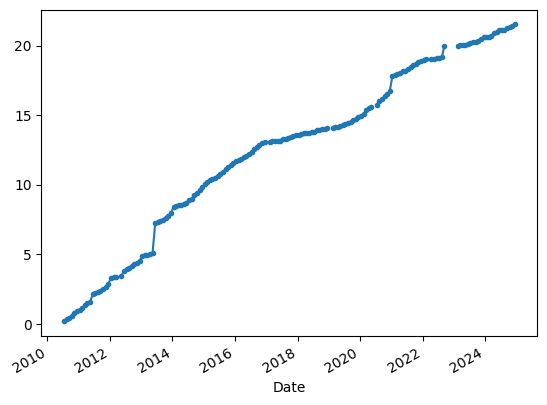

: 

In [ ]:
start_date = pd.to_datetime('01/01/2010')
display(basis_tab_filtered.mean(axis=1).loc[start_date:].describe())
(-basis_tab_filtered).mean(axis=1).loc[start_date:].cumsum().plot(marker='.')

## debug

In [91]:
coupon = 5
r = 0
set_date_1 = pd.to_datetime('01/13/2024')
set_date_2 = pd.to_datetime('02/13/2024')
spot_price = 100
yearly_cpr = 10
roll_date = 13


In [92]:
Y = np.arange(0,60,1)
samy = [100*calculate_current_forward(set_date_1, 1, spot_price/100, coupon, r, y/100, roll_date)
        for y in Y]

In [93]:
me = [forward_mbs_price(
    set_date_1, set_date_2, spot_price, coupon, r, y
) for y in Y]

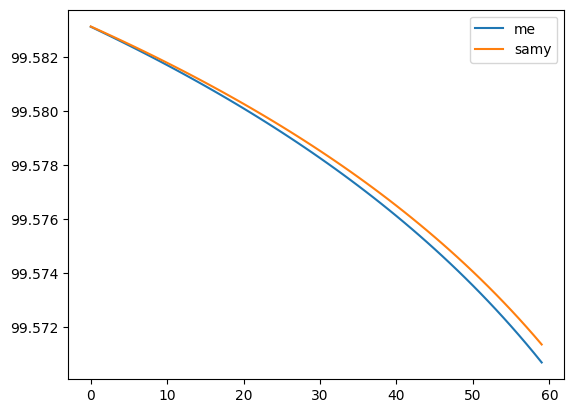

In [94]:
from matplotlib import pyplot as plt

plt.plot(Y, me, label='me')
plt.plot(Y, samy, label='samy')
plt.legend()